In [94]:
import pandas as pd
import json, os

import tensorflow as tf
import numpy as np
import csv
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification #, BertModel, BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from collections import OrderedDict
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import random
import io

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D

from sklearn.metrics import classification_report
from keras_preprocessing.text import tokenizer_from_json

import nltk
from nltk.tokenize import word_tokenize

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier


In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
embeddings = ["w2v", "ft", "bert", "codebert"]
embedding = embeddings[2]

Choose a project among Chrome and Linux or the full dataset

In [4]:
#data = pd.read_csv(os.path.join('..','data', 'full_data_reduced.csv'))
#data = pd.read_csv(os.path.join('..','data', 'chrome_data_reduced.csv'))
data = pd.read_csv(os.path.join('..','data', 'linux_data_reduced.csv'))

Shuffle the dataset before starting operating on it

In [5]:
data = data.sample(frac=1, random_state=seed).reset_index(drop=True)

In [6]:
print(data.head())

                                                func  vul  length
0  static inline void __ap_schedule_poll_timer(vo...    0      30
1  static int sctp_autobind(struct sock *sk)\n{\n...    0      36
2  static ssize_t ucma_init_qp_attr(struct ucma_f...    0      88
3  static void __blk_mq_requeue_request(struct re...    0      24
4  static void vhost_net_flush(struct vhost_net *...    0      37


In [7]:
np.max(data["length"])

237

In [8]:
word_counts = data["func"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
print("Maximum number of words:", max_length)


Maximum number of words: 237


In [9]:
print(data["vul"].value_counts())

print("Vulnerability Percentage: ", (data["vul"].value_counts()[1]/data["vul"].value_counts()[0])*100, '%')

0    43024
1     1439
Name: vul, dtype: int64
Vulnerability Percentage:  3.344644849386389 %


PRE_PROCESSING

In [10]:
nltk.download('punkt')

tokenized_list = [word_tokenize(sentence) for sentence in data["func"].tolist()]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iliaskaloup\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BERT pre-trained embeddings

In [11]:
if embedding == "bert":
    model_variation = "bert-base-uncased" # "roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_variation)
    bert = TFAutoModel.from_pretrained(model_variation)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
if embedding == "bert": 
    sentences = data["func"].tolist()

    sequences = [tokenizer.encode(sente, truncation=True, max_length=512, padding="max_length", add_special_tokens=False, return_tensors="tf") for sente in sentences]
    embeddings = [bert(sequence)[0][:, 0, :].numpy() for sequence in sequences]  # Extract embeddings from BERT's output
    extracted_embeddings = [arr[0] for arr in embeddings]

KeyboardInterrupt: 

CodeBERT pre-trained CPP embeddings

In [15]:
if embedding == "codebert":
    model_variation = "microsoft/codebert-base-mlm" # "neulab/codebert-cpp"
    tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=False) # , do_lower_case=True
    codebert = TFAutoModel.from_pretrained(model_variation) # , from_pt=True

In [16]:
if embedding == "codebert": 
    sentences = data["func"].tolist()

    sequences = [tokenizer.encode(sente, truncation=True, max_length=512, padding="max_length", add_special_tokens=False, return_tensors="tf") for sente in sentences]
    embeddings = [codebert(sequence)[0][:, 0, :].numpy() for sequence in sequences]  # Extract embeddings from CodeBERT's output
    extracted_embeddings = [arr[0] for arr in embeddings]

Train-val-test split

In [85]:
# split data into train and test and then train into train and val (90% train, 10% test and then 90% train and 20% val)
shuffle_seeders = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
shuffle_seeder = shuffle_seeders[0]

x_train_val, x_test, y_train_val, y_test = train_test_split(extracted_embeddings, data["vul"].tolist(), stratify = data["vul"].tolist(), test_size=0.1, random_state=shuffle_seeder)

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify = y_train_val, test_size=0.1, random_state=shuffle_seeder)


In [92]:
# Convert labels to integers
y_train_val = [int(label) for label in y_train_val]
y_test = [int(label) for label in y_test]
y_train = [int(label) for label in y_train]
y_val = [int(label) for label in y_val]

In [95]:
userModels = ["RF", "SVM", "DT", "NB", "KNN", "LR"]
userModel = userModels[0]

if userModel == "svm":
    myModel = SVC(kernel='rbf', gamma=100)
elif userModel == "RF":
    myModel = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
elif userModel == "DT":
    myModel = tree.DecisionTreeClassifier(max_depth=120)
elif userModel == "NB":
    myModel = GaussianNB()

Hyperparameter tuning - Validation

TP= 0
TN= 266
FP= 0
FN= 9
Accuracy:96.73%
Precision:0.00%
Recall:0.00%
F1 score:0.00%
Roc_Auc score:50.00%
F2 score:nan%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       266
           1       0.00      0.00      0.00         9

    accuracy                           0.97       275
   macro avg       0.48      0.50      0.49       275
weighted avg       0.94      0.97      0.95       275



D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

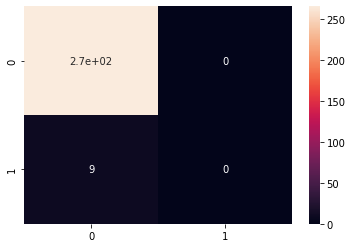

In [97]:
# Training
myModel.fit(x_train, y_train) # y_train.ravel()

# Predicting
predictions = myModel.predict(x_val)
#predScores = myModel.predict_proba(x_val)

# Evaluation
accuracy = accuracy_score(y_val, predictions)
precision = precision_score(y_val, predictions)
recall = recall_score(y_val, predictions)
f1 = f1_score(y_val, predictions)
roc_auc = roc_auc_score(y_val, predictions)
f2 = 5*precision*recall / (4*precision+recall)

cm = confusion_matrix(y_val, predictions, labels=[0, 1])
#print(cm)
sns.heatmap(cm, annot=True)
tn, fp, fn, tp = cm.ravel()

print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("F1 score:%.2f%%"%(f1*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F2 score:%.2f%%"%(f2*100))
print(classification_report(y_val, predictions))

Evaluation

In [ ]:
# # Training
# myModel.fit(x_train_val, y_train_val) # y_train.ravel()

# # Predicting
# predictions = myModel.predict(x_test)
# #predScores = myModel.predict_proba(x_test)

# # Evaluation
# accuracy = accuracy_score(y_test, predictions)
# precision = precision_score(y_test, predictions)
# recall = recall_score(y_test, predictions)
# f1 = f1_score(y_test, predictions)
# roc_auc = roc_auc_score(y_test, predictions)
# f2 = 5*precision*recall / (4*precision+recall)

# cm = confusion_matrix(y_test, predictions, labels=[0, 1])
# #print(cm)
# sns.heatmap(cm, annot=True)
# tn, fp, fn, tp = cm.ravel()

# print("TP=",tp)
# print("TN=",tn)
# print("FP=",fp)
# print("FN=",fn)

# print("Accuracy:%.2f%%"%(accuracy*100))
# print("Precision:%.2f%%"%(precision*100))
# print("Recall:%.2f%%"%(recall*100))
# print("F1 score:%.2f%%"%(f1*100))
# print("Roc_Auc score:%.2f%%"%(roc_auc*100))
# print("F2 score:%.2f%%"%(f2*100))
# print(classification_report(Y_test, predictions))